# <u>Submission instructions</u>
### Submission in pairs unless otherwise authorized
<ul style="font-size: 17px">
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for both theoretical and practical parts should be written in this notebook</li>
</ul>

<h3> Moodle submission</h3>


<p style="font-size: 17px">
You should submit three files:
</p>
<ul style="font-size: 17px">
<li>IPYNB notebook:
  <ul>
  <li>All the wet and dry parts, including code, graphs, discussion, etc.</li>
  </ul>
</li>
<li>PDF file:
  <ul>
  <li>Export the notebook to PDF. Make sure that all the cells are visible.</li>
  </ul>
</li>
</ul>
<p style="font-size: 17px">
All files should be in the following format: "HW2_ID1_ID2.file"
<br>
Good Luck!
</p>

# Question 1 - Generalizrtion and Overfit (30 pt)

<p style="font-size: 17px"> In this exercise, we will demonstrate overfitting to random labels.The settings are the following:
<ul style="font-size: 17px">
<li> Use the MNIST dataset.
<li> Work on the first 128 samples from the training dataset.
<li> Fix the following parameters:
    <ul>
        <li> Shuffle to False.
        <li> Batch size to 128.
    </ul>
<li> Generate random labels from Bernoulli distribution with a probability of $\frac{1}{2}$. I.e.,each sample is assigned a random label which is zero or one.
</ul>

<p style="font-size: 17px">
Show that by using a Fully Connected netwrok and cross-entropy loss, you are able to achieve a loss value of ~0 (the lower the better).
Plot the accuracy and loss convergence for this data and the test data as a function of epochs.
What is the accuracy value of the test data? Explain
</p>

In [2]:
# Import necessary libraries
import numpy as np
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from torch.autograd import Variable
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor()])

# Loading the data and splitting to train and test
train_set = datasets.MNIST('',train = True,transform=transform,download=True)
test_set = datasets.MNIST('',train = False,transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size= test_set.__len__(),shuffle=False)

In [4]:
#Creare random labels with the Bernoulli probability
#128 on the train and all for the test

train = enumerate(train_loader)
_, (train_images, labels) = next(train)
random_labels_train = bernoulli.rvs(0.5, size=128)
random_labels_train_tensor = torch.Tensor(random_labels_train).long()

test = enumerate(test_loader)
_, (test_images, _) = next(test)
random_labels_test = bernoulli.rvs(0.5, size=len(test_images))
random_labels_test_tensor = torch.Tensor(random_labels_test).long()

In [5]:
#We chose parameter 50 because of the complexity of the model, with parameter = 200 the kernel was shot down

class Fully_Connected_Network(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Fully_Connected_Network, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [6]:
#Helping functions

def to_var(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return x.to(device)


def get_accuracy(images, labels, predictions, accuracy_list):
    count = len(images)  
    correct = sum(pred == label for label, pred in zip(labels, predictions))
    accuracy_list.append(correct / count)
    return correct / count

In [7]:
#Collecting the losses

loss_train = []
loss_test = []

#Collecting the accuracies

accuracy_train, accuracy_test = [],[]


model = Fully_Connected_Network(28*28, 2)


if torch.cuda.is_available():
    model = model.cuda()


loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#Loop on 500 epochs
for epoch in range(500):
    images = to_var(train_images.view(-1, 28 * 28))
    labels = to_var(random_labels_train_tensor)

    #Train
    optimizer.zero_grad()
    outputs = model.forward(images)
    _, predictions = torch.max(outputs.data, 1)
    train_loss = loss_func(outputs, labels) # train loss
    train_loss.backward()
    optimizer.step()
    loss_train.append(train_loss.item())
    train_accuracy = get_accuracy(images, labels, predictions, accuracy_train) #accuracy

    #Test
    images = to_var(test_images.view(-1, 28 * 28))
    labels = to_var(random_labels_test_tensor)
    outputs = model.forward(images)
    _, predictions = torch.max(outputs.data, 1)
    test_loss = loss_func(outputs, labels)# test loss
    test_accuracy = get_accuracy(images, labels, predictions, accuracy_test)#acuracy
    loss_test.append(test_loss.item())
    if epoch%50 ==0:
        print(f"epoch {epoch}: Train loss: {train_loss}, Train accuracy: {train_accuracy}, Test loss: {test_loss}, Test accuracy: {test_accuracy} ")

epoch 0: Train loss: 0.6937936544418335, Train accuracy: 0.515625, Test loss: 0.6942481994628906, Test accuracy: 0.49959999322891235 
epoch 50: Train loss: 0.48510730266571045, Train accuracy: 0.8671875, Test loss: 0.7542756199836731, Test accuracy: 0.48829999566078186 
epoch 100: Train loss: 0.30289044976234436, Train accuracy: 0.90625, Test loss: 0.9780857563018799, Test accuracy: 0.4885999858379364 
epoch 150: Train loss: 0.1578729748725891, Train accuracy: 0.9765625, Test loss: 1.1721075773239136, Test accuracy: 0.4878000020980835 
epoch 200: Train loss: 0.07920797169208527, Train accuracy: 1.0, Test loss: 1.3449560403823853, Test accuracy: 0.48669999837875366 
epoch 250: Train loss: 0.05037228390574455, Train accuracy: 1.0, Test loss: 1.493015170097351, Test accuracy: 0.4871000051498413 
epoch 300: Train loss: 0.035241350531578064, Train accuracy: 1.0, Test loss: 1.611161231994629, Test accuracy: 0.4887999892234802 
epoch 350: Train loss: 0.02630339004099369, Train accuracy: 1.0, 

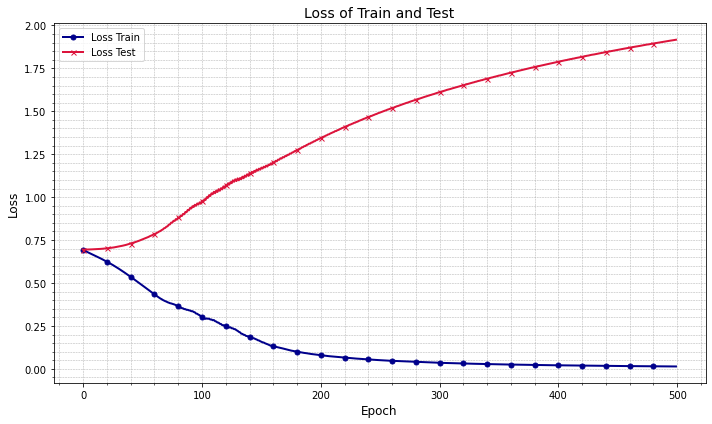

In [10]:
epochs_list = list(range(500))
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, loss_train, label="Loss Train", color="darkblue", linestyle='-', linewidth=2, marker='o', markersize=5, markevery=20)
plt.plot(epochs_list, loss_test, label="Loss Test", color="crimson", linestyle='-', linewidth=2, marker='x', markersize=5, markevery=20)

plt.legend(loc="upper left", fontsize=10)
plt.title("Loss of Train and Test", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()


plt.tight_layout()
plt.show()

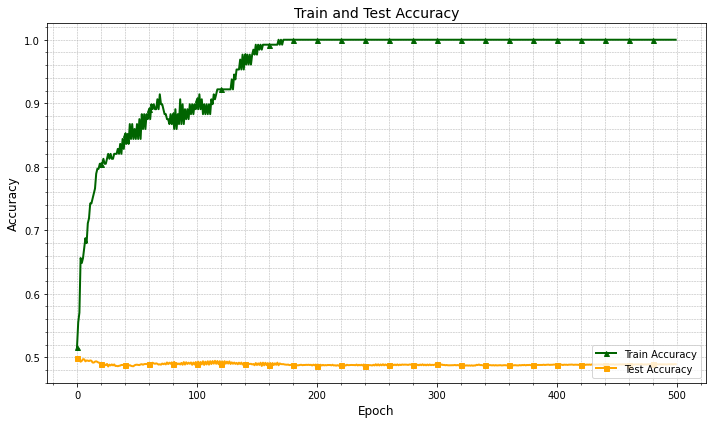

In [11]:
epochs_list = list(range(500))
plt.figure(figsize=(10, 6))

plt.plot(epochs_list, accuracy_train, label="Train Accuracy", color="darkgreen", linestyle='-', linewidth=2, marker='^', markersize=5, markevery=20)
plt.plot(epochs_list, accuracy_test, label="Test Accuracy", color="orange", linestyle='-', linewidth=2, marker='s', markersize=5, markevery=20)

plt.title("Train and Test Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.legend(loc="lower right", fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

The results clearly show overfitting: the training accuracy approaches 1, demonstrating that the model has learned to perfectly predict the randomly assigned labels. Conversely, the test accuracy stagnates around 0.5, indicating that the model's learned patterns do not generalize to new data. This outcome is expected since the labels are randomly generated. The training loss nearing zero further confirms the model's fit to the training data, while the rising test loss signifies its struggle with the test set.

<h1> Question 2 - Sentiment Analysis - Classification (70 pt)</h1>

### a) EDA (10 pt)

<p style="font-size: 17px">
Explore and analyze your data. Explain your data cleaning and processing pipeline.
</p>

In [1]:
import pandas as pd

# Load the CSV files into DataFrames, skipping the first row which is not needed
train_data = pd.read_csv('trainEmotions.csv', header=None, names=['Emotion', 'Text'], skiprows=1)
test_data = pd.read_csv('testEmotions.csv', header=None, names=['Emotion', 'Text'], skiprows=1)

# Function to sample n random rows from a DataFrame
def sample_n(df, n):
    return df.sample(n)

# Display 5 random rows from each label for the training data
print("\nTrain Data Random Sample:")
random_train_samples = train_data.groupby('Emotion').apply(sample_n, n=5).reset_index(drop=True)
print(random_train_samples)

# Display 5 random rows from each label for the test data
print("\nTest Data Random Sample:")
random_test_samples = test_data.groupby('Emotion').apply(sample_n, n=5).reset_index(drop=True)
print(random_test_samples)


Train Data Random Sample:
      Emotion                                               Text
0   happiness  Today is check in day for week 12 of the Artis...
1   happiness  finally packed...thinking its time for some sl...
2   happiness  @iamoph i just want you to know, im still here...
3   happiness  To all mothers out there in Twitterland: Happy...
4   happiness  Hey @robluketic its back!!    (robluketic live...
5     neutral  @ggenung gables apartments has corporate and t...
6     neutral  my wack friends are all raiding my kitchen. RE...
7     neutral  Invisible car helps to boost recycling. Honest...
8     neutral  @juliaakes hahaha, perfect, my procrastination...
9     neutral  Mother's Day - cherrylolita: Thatï¿½s not true...
10    sadness  Today in the friendly game one asshole hit me ...
11    sadness  @kenyaimagine ... much more injustice than we ...
12    sadness  Bout to get ready for work ugh i hate workin o...
13    sadness  @hithit  missing jmichelle... told you treat m..


C:\Users\user\AppData\Local\Temp\ipykernel_19292\50479856.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_train_samples = train_data.groupby('Emotion').apply(sample_n, n=5).reset_index(drop=True)
C:\Users\user\AppData\Local\Temp\ipykernel_19292\50479856.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_test_samples = test_data.groupby('Emotion').apply(sample_n, n=5).reset_index(drop=T

Looking at random samples from the dataset, we can see that each input contains a relatively short sentence. The presence of user mentions (e.g., "@username") in the text samples hints at a possible social media origin, like Twitter. We will remove these mentions as they are not relevant for sentiment analysis. We will keep some punctuation marks as they can add additional sentiment information, such as smileys ':)' and '...' . The rest, such as '#','&' will be removed.

In [2]:
import re

# Function to clean the text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'@\w+', '', text)  # Remove username mentions
    # Retaining '.', '!', '?', '...', ':', '(', and ')' as they can be significant for sentiment analysis
    # Removing other punctuation marks
    text = re.sub(r"[^a-zA-Z0-9.!?...:()]+", ' ', text)

    return text

# Display the uncleaned text
print("\nUncleaned Train Data Text Example:")
print(train_data['Text'].head())

# Apply the cleaning function to the text column
train_data['Text'] = train_data['Text'].apply(clean_text)
test_data['Text'] = test_data['Text'].apply(clean_text)

# Save the cleaned text, we will later use it
train_data.to_csv('cleaned_trainEmotions.csv', index=False)
test_data.to_csv('cleaned_testEmotions.csv', index=False)

# Display the cleaned text
print("\nCleaned Train Data Text Example:")
print(train_data['Text'].head())


Uncleaned Train Data Text Example:
0    victory for the bulldogs was celebrated by 3 w...
1                       @saraLDS Thanks for that, Sara
2    @Tony_Mandarich well welcome back from the dar...
3              @sai_shediddy lol , you gotta share too
4    first up, make up for lost time with jelly. Ja...
Name: Text, dtype: object

Cleaned Train Data Text Example:
0    victory for the bulldogs was celebrated by 3 w...
1                                 thanks for that sara
2                well welcome back from the dark side!
3                              lol you gotta share too
4    first up make up for lost time with jelly. jal...
Name: Text, dtype: object


In [3]:
# Check for any missing values in the datasets
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())

# Explore the distribution of the emotion labels
print("\nEmotion Distribution in Training Data:")
print(train_data['Emotion'].value_counts())

print("\nEmotion Distribution in Test Data:")
print(test_data['Emotion'].value_counts())


Missing Values in Training Data:
Emotion    0
Text       0
dtype: int64

Missing Values in Test Data:
Emotion    0
Text       0
dtype: int64

Emotion Distribution in Training Data:
Emotion
happiness    5430
neutral      5182
sadness      3892
Name: count, dtype: int64

Emotion Distribution in Test Data:
Emotion
happiness    1811
neutral      1728
sadness      1298
Name: count, dtype: int64


We can see that there are no missing values in our dataset, and we have slightly less 'sadness' labeled sentences than 'happiness' and 'neutral'.

### Exercise
<p style="font-size: 17px">
The goal of this exercise is to get familiar with recurrent neural networks. 
<br><br>
The field of detecting which emotion is represented in a text is developing and being
studied due to its usefulness. For example, detecting if a review is positive or
negative and more.
<br><br>
In this exercise, you will detect the emotion of a sentence. You should get at least 47% accuracy on the test set.
<br><br>
You should
<ul style="font-size: 17px">
  <li> Try different model architectures - Vanilla RNN and Gated model (GRU/LSTM)</li>
  <li> Use different optimization and regularization methods </li>
  <li> Try different combinations of hyperparamters</li>
</ul>
</p>

<br>

### Data

<p style="font-size: 17px">
The data is a csv file containing tweets and their labels according to the emotion –
{happiness, sadness, neutral}. Every row in the file (except for the header) is an
example. 
<br>
Examples: (Notepad++ view)
<ul style="font-size: 17px">
  <li> happiness,Welcome @doeko ! Really glad to know you here. Your products rox man</li>
  <li> sadness,Disappointment really sucks! I'm getting used to it.</li>
  <li> neutral,I just want to Sleep.</li>
</ul>
<p style="font-size: 17px">
You have a train file – "trainEmotions.csv" and a test file – "testEmotions.csv". Both files can be found in the "HW2_data.zip" file.
</p>

*****************************

### b) Main (50 pt)

<p style="font-size: 17px">
Define 2 models, as requested. Train and eval them.
<ul style="font-size: 17px">
<li> Plot the gated model's accuracy and loss (both on train and test sets) as a function of the epochs.
<li> Plot a confusion matrix
</ul>

</p>

**Creating our custom dataset and define the models**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

class EmotionDataset(Dataset):
    def __init__(self, csv_file, tokenizer, vocab=None):
        self.data = pd.read_csv(csv_file, skiprows=1, names=['Emotion', 'Text'])
        self.data=self.data.astype(str)
        self.tokenizer = tokenizer
        self.labels = {'happiness': 2, 'sadness': 0, 'neutral': 1}  # Label mapping
        
        if vocab is None:
            self.vocab = build_vocab_from_iterator(self.tokenized_texts(), specials=["<unk>"])
            self.vocab.set_default_index(self.vocab["<unk>"])
        else:
            self.vocab = vocab

    def tokenized_texts(self):
        for text in self.data['Text']:
            yield self.tokenizer(text)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.tokenizer(self.data.iloc[idx]['Text'])
        label = self.labels[self.data.iloc[idx]['Emotion']]
        return torch.tensor([self.vocab[token] for token in text], dtype=torch.long), label

# Function the DataLoader uses for batch handling
def collate_batch(batch):
    label_list, text_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        text_list.append(_text)
    return pad_sequence(text_list, padding_value=0.0, batch_first=True), torch.tensor(label_list, dtype=torch.int64)

# Define tokenizer
tokenizer = get_tokenizer('basic_english')

# Create the full train dataset
train_dataset = EmotionDataset('cleaned_trainEmotions.csv', tokenizer)


# Split the full train dataset into training and validation subsets
total_size = len(train_dataset)
train_size = int(total_size * 0.8)
val_size = total_size - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for the training and validation subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, collate_fn=collate_batch)

# Create the test dataset and DataLoader
test_dataset = EmotionDataset('cleaned_testEmotions.csv', tokenizer, vocab=train_dataset.vocab)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout_p = 0):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, nonlinearity='relu')
        self.fc_dropout = nn.Dropout(dropout_p)  # dropout before the fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)  # embedded: [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded)  # output: [batch_size, seq_length, hidden_dim]
                                             # hidden: [1, batch_size, hidden_dim]
        hidden = hidden[-1]  # hidden: [batch_size, hidden_dim]
        hidden = self.fc_dropout(hidden)  # Apply dropout before the fully connected layer
        return self.fc(hidden)
    
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout_p = 0):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden.squeeze(0)  # Get the last hidden state
        hidden = self.dropout(hidden)  # Apply dropout after squeezing the hidden state
        return self.fc(hidden)

input_dim = len(train_dataset.vocab)
output_dim = len(train_dataset.labels)

# LSTM Model

The method we will use is a greedy selection of parameters: we will start by trying out different hidden layer sizes (with the rest of parameters fixed) and pick the best one. Then we will try out different learning rates, using the selected hidden size. Then we will choose a dropout rate using the same logic. The same method will be used for selecting parameters for the RNN model. 

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=2, should_draw=False, val_or_test='Validation'):
    model.to(device)
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    patience = 3
    best_test_accuracy = 0
    best_model_state = None
    best_predictions = None
    best_labels = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_labels = []
        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts)
                loss = criterion(predictions, labels)
                test_loss += loss.item()
                _, predicted = torch.max(predictions.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_predictions.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100 * test_correct / test_total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%, {val_or_test} Loss: {epoch_test_loss:.4f}, {val_or_test} Accuracy: {epoch_test_acc:.2f}%')

        # Update best model if improved
        if epoch_test_acc > best_test_accuracy:
            best_test_accuracy = epoch_test_acc
            best_model_state = model.state_dict()
            best_predictions = test_predictions
            best_labels = test_labels
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Stopping early at epoch {epoch+1}')
                break

    if should_draw:
        # Load the best model for evaluation
        model.load_state_dict(best_model_state)

        print(f'Best {val_or_test} accuracy: {best_test_accuracy}')          
        # Plotting
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(best_labels, best_predictions)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return best_test_accuracy

*****************************

In [ ]:
criterion = nn.CrossEntropyLoss()
# Move to GPU, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_embedding_dim = 100

In [8]:
# trying out different hidden layer dimensions for our LSTM model

hidden_dims = [32, 64, 128, 256, 512]  
best_test_accuracy = 0
best_hidden_dim_LSTM = None
num_epochs = 16

for hidden_dim in hidden_dims:
    print(f"Training LSTM with hidden dimension: {hidden_dim}")
    lstm_model = LSTM(input_dim, lstm_embedding_dim, hidden_dim, output_dim)
    lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)  # Use an appropriate learning rate
    test_accuracy = train_and_evaluate(lstm_model, train_loader, val_loader, lstm_optimizer, criterion, device, num_epochs)
    print(f"Test Accuracy for hidden dimension {hidden_dim}: {test_accuracy}%")
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_hidden_dim_LSTM = hidden_dim

print(f"Best hidden dimension is: {best_hidden_dim_LSTM} with an accuracy of: {best_test_accuracy}%")

Training LSTM with hidden dimension: 32

Epoch 1: Train Loss: 1.0858, Train Accuracy: 37.79%, Validation Loss: 1.0703, Validation Accuracy: 42.40%
Epoch 2: Train Loss: 1.0441, Train Accuracy: 46.51%, Validation Loss: 1.0219, Validation Accuracy: 48.81%
Epoch 3: Train Loss: 0.9274, Train Accuracy: 57.50%, Validation Loss: 0.9732, Validation Accuracy: 54.50%
Epoch 4: Train Loss: 0.8037, Train Accuracy: 65.80%, Validation Loss: 0.9622, Validation Accuracy: 56.26%
Epoch 5: Train Loss: 0.6957, Train Accuracy: 71.75%, Validation Loss: 0.9728, Validation Accuracy: 58.08%
Epoch 6: Train Loss: 0.5916, Train Accuracy: 77.54%, Validation Loss: 0.9762, Validation Accuracy: 59.53%
Epoch 7: Train Loss: 0.5104, Train Accuracy: 81.27%, Validation Loss: 1.0535, Validation Accuracy: 58.39%
Epoch 8: Train Loss: 0.4475, Train Accuracy: 83.87%, Validation Loss: 1.0814, Validation Accuracy: 58.67%
Epoch 9: Train Loss: 0.3875, Train Accuracy: 86.74%, Validation Loss: 1.2104, Validation Accuracy: 57.29%
Stopp

In [9]:
# trying out different learning rates for our LSTM model
learning_rates = [0.1, 0.01,0.005, 0.001, 0.0001]
best_test_accuracy = 0
best_lr_LSTM = None
num_epochs = 16
for lr in learning_rates:
    print(f"Training LSTM with learning rate: {lr}")
    lstm_model = LSTM(input_dim, lstm_embedding_dim, best_hidden_dim_LSTM, output_dim)
    lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
    test_accuracy = train_and_evaluate(lstm_model, train_loader, val_loader, lstm_optimizer, criterion, device, num_epochs)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_lr_LSTM = lr


print(f"Best learning rate is: {best_lr_LSTM} with an accuracy of: {best_test_accuracy}")

Training LSTM with learning rate: 0.1

Epoch 1: Train Loss: 1.9146, Train Accuracy: 34.16%, Validation Loss: 1.1673, Validation Accuracy: 37.06%
Epoch 2: Train Loss: 1.5324, Train Accuracy: 35.04%, Validation Loss: 1.4037, Validation Accuracy: 37.95%
Epoch 3: Train Loss: 1.3706, Train Accuracy: 36.77%, Validation Loss: 1.4336, Validation Accuracy: 36.95%
Epoch 4: Train Loss: 1.2780, Train Accuracy: 38.40%, Validation Loss: 1.3911, Validation Accuracy: 39.12%
Epoch 5: Train Loss: 1.2258, Train Accuracy: 38.59%, Validation Loss: 1.2474, Validation Accuracy: 36.44%
Epoch 6: Train Loss: 1.2362, Train Accuracy: 38.82%, Validation Loss: 1.5121, Validation Accuracy: 36.99%
Epoch 7: Train Loss: 1.2962, Train Accuracy: 39.17%, Validation Loss: 1.2614, Validation Accuracy: 35.40%
Stopping early at epoch 7
Training LSTM with learning rate: 0.01
Epoch 1: Train Loss: 1.1051, Train Accuracy: 38.94%, Validation Loss: 1.0676, Validation Accuracy: 43.09%
Epoch 2: Train Loss: 1.0161, Train Accuracy: 49.

In [10]:
# trying out different dropout probabilities (for controling regularization)
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]
best_test_accuracy = 0
best_dropout_rate_LSTM = None
num_epochs = 16

for dropout_rate in dropout_rates:
    print(f"Training LSTM with dropout rate: {dropout_rate}")
    lstm_model = LSTM(input_dim, lstm_embedding_dim, best_hidden_dim_LSTM, output_dim, dropout_rate)
    lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=best_lr_LSTM)  # Set your optimal learning rate
    test_accuracy = train_and_evaluate(lstm_model, train_loader, val_loader, lstm_optimizer, criterion, device, num_epochs)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_dropout_rate_LSTM = dropout_rate

print(f"Best dropout rate is: {best_dropout_rate_LSTM} with an accuracy of: {best_test_accuracy}")

Training LSTM with dropout rate: 0.0

Epoch 1: Train Loss: 1.0886, Train Accuracy: 38.05%, Validation Loss: 1.0716, Validation Accuracy: 41.95%
Epoch 2: Train Loss: 1.0548, Train Accuracy: 45.07%, Validation Loss: 1.0476, Validation Accuracy: 45.64%
Epoch 3: Train Loss: 0.9993, Train Accuracy: 50.93%, Validation Loss: 0.9858, Validation Accuracy: 52.88%
Epoch 4: Train Loss: 0.8975, Train Accuracy: 60.78%, Validation Loss: 0.9506, Validation Accuracy: 56.02%
Epoch 5: Train Loss: 0.7793, Train Accuracy: 68.04%, Validation Loss: 0.9283, Validation Accuracy: 57.84%
Epoch 6: Train Loss: 0.6702, Train Accuracy: 73.76%, Validation Loss: 0.9670, Validation Accuracy: 59.46%
Epoch 7: Train Loss: 0.5604, Train Accuracy: 78.71%, Validation Loss: 1.0183, Validation Accuracy: 58.67%
Epoch 8: Train Loss: 0.4561, Train Accuracy: 83.44%, Validation Loss: 1.0659, Validation Accuracy: 58.43%
Epoch 9: Train Loss: 0.3483, Train Accuracy: 88.05%, Validation Loss: 1.1482, Validation Accuracy: 59.53%
Epoch 10

Epoch 1: Train Loss: 1.0893, Train Accuracy: 37.42%, Test Loss: 1.0811, Test Accuracy: 44.41%
Epoch 2: Train Loss: 1.0588, Train Accuracy: 44.15%, Test Loss: 1.0722, Test Accuracy: 44.59%
Epoch 3: Train Loss: 1.0051, Train Accuracy: 50.47%, Test Loss: 1.0681, Test Accuracy: 44.47%
Epoch 4: Train Loss: 0.8925, Train Accuracy: 60.67%, Test Loss: 1.0907, Test Accuracy: 46.16%
Epoch 5: Train Loss: 0.7699, Train Accuracy: 68.51%, Test Loss: 1.1087, Test Accuracy: 49.00%
Epoch 6: Train Loss: 0.6498, Train Accuracy: 75.14%, Test Loss: 1.2480, Test Accuracy: 46.29%
Epoch 7: Train Loss: 0.5260, Train Accuracy: 80.69%, Test Loss: 1.3773, Test Accuracy: 46.97%
Epoch 8: Train Loss: 0.4253, Train Accuracy: 85.35%, Test Loss: 1.5871, Test Accuracy: 47.03%
Stopping early at epoch 8
Best Test accuracy: 48.99731238370891





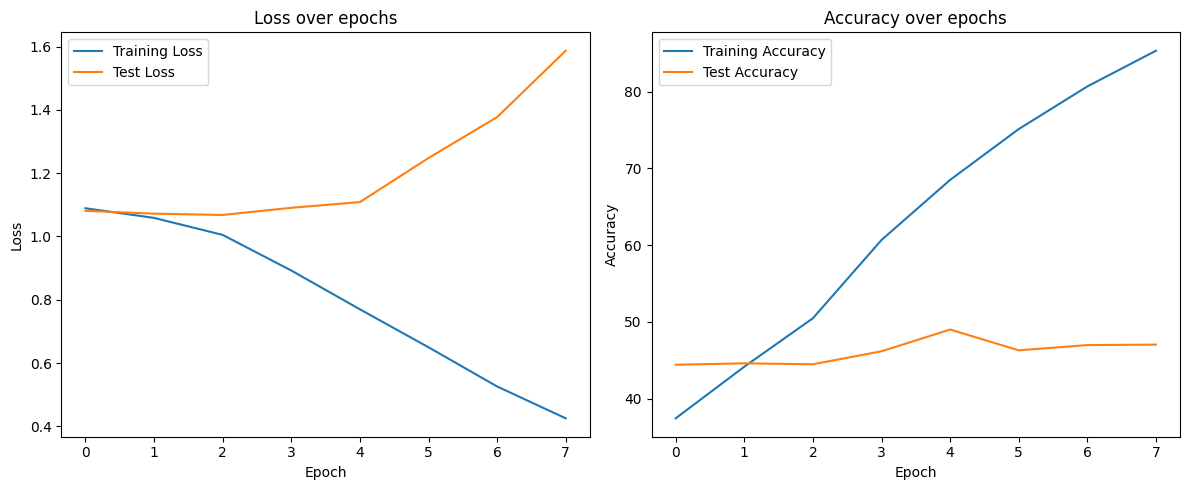

<Figure size 1200x500 with 2 Axes>

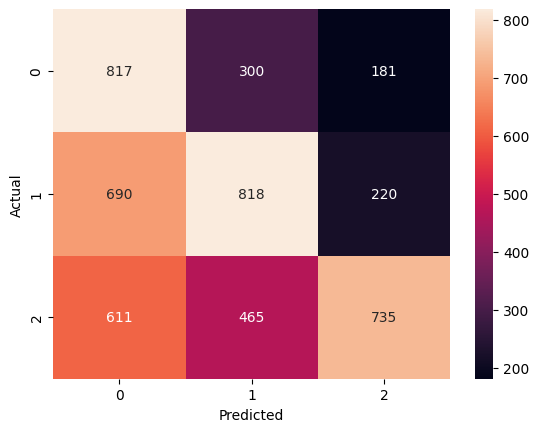

<Figure size 640x480 with 2 Axes>

48.99731238370891

In [11]:
# evaluating our chosen model on the test dataset, showing graphs and confusion matrix:
lstm_model = LSTM(input_dim, lstm_embedding_dim, best_hidden_dim_LSTM, output_dim, best_dropout_rate_LSTM)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=best_lr_LSTM)  
train_and_evaluate(lstm_model, train_loader, test_loader, lstm_optimizer, criterion, device, num_epochs,True,'Test')

# RNN Model

In [ ]:
criterion = nn.CrossEntropyLoss()
# Move to GPU, if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_embedding_dim = 100

In [13]:
# trying out different hidden layer dimensions for our RNN model

hidden_dims = [32, 64, 128, 256, 512]  
best_test_accuracy = 0
best_hidden_dim_RNN = None
num_epochs = 16

for hidden_dim in hidden_dims:
    print(f"Training RNN with hidden dimension: {hidden_dim}")
    rnn_model = RNN(input_dim, rnn_embedding_dim, hidden_dim, output_dim)
    rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)  
    test_accuracy = train_and_evaluate(rnn_model, train_loader, val_loader, rnn_optimizer, criterion, device, num_epochs)
    print(f"Test Accuracy for hidden dimension {hidden_dim}: {test_accuracy}%")
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_hidden_dim_RNN = hidden_dim

print(f"Best hidden dimension for RNN is: {best_hidden_dim_RNN} with an accuracy of: {best_test_accuracy}%")

Training RNN with hidden dimension: 32

Epoch 1: Train Loss: 1.0901, Train Accuracy: 37.14%, Validation Loss: 1.0844, Validation Accuracy: 37.44%
Epoch 2: Train Loss: 1.0890, Train Accuracy: 37.26%, Validation Loss: 1.0989, Validation Accuracy: 37.37%
Epoch 3: Train Loss: 1.0868, Train Accuracy: 37.48%, Validation Loss: 1.0869, Validation Accuracy: 37.40%
Epoch 4: Train Loss: 1.0865, Train Accuracy: 37.95%, Validation Loss: 1.0852, Validation Accuracy: 37.54%
Epoch 5: Train Loss: 1.0840, Train Accuracy: 37.88%, Validation Loss: 1.0844, Validation Accuracy: 37.37%
Epoch 6: Train Loss: 1.0851, Train Accuracy: 37.95%, Validation Loss: 1.0836, Validation Accuracy: 37.50%
Epoch 7: Train Loss: 1.0845, Train Accuracy: 37.71%, Validation Loss: 1.0853, Validation Accuracy: 37.44%
Stopping early at epoch 7
Test Accuracy for hidden dimension 32: 37.5387797311272%
Training RNN with hidden dimension: 64
Epoch 1: Train Loss: 1.0923, Train Accuracy: 37.17%, Validation Loss: 1.0840, Validation Accurac

In [14]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]
best_test_accuracy = 0
best_lr_RNN = None
num_epochs = 16
for lr in learning_rates:
    print(f"Training RNN with learning rate: {lr}")
    rnn_model = RNN(input_dim, rnn_embedding_dim, best_hidden_dim_RNN, output_dim)
    rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=lr)
    test_accuracy = train_and_evaluate(rnn_model, train_loader, val_loader, rnn_optimizer, criterion, device,num_epochs,False)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_lr_RNN = lr


print(f"Best learning rate for the RNN is: {best_lr_RNN} with an accuracy of: {best_test_accuracy}")

Training RNN with learning rate: 0.1

Epoch 1: Train Loss: 25955015715.3742, Train Accuracy: 38.02%, Validation Loss: 1.3216, Validation Accuracy: 37.44%
Epoch 2: Train Loss: 1.3507, Train Accuracy: 36.35%, Validation Loss: 1.3315, Validation Accuracy: 37.33%
Epoch 3: Train Loss: 1.2560, Train Accuracy: 36.30%, Validation Loss: 1.4312, Validation Accuracy: 37.37%
Epoch 4: Train Loss: 1.3725, Train Accuracy: 36.95%, Validation Loss: 1.7773, Validation Accuracy: 37.26%
Stopping early at epoch 4
Training RNN with learning rate: 0.01
Epoch 1: Train Loss: 1.0965, Train Accuracy: 37.33%, Validation Loss: 1.0918, Validation Accuracy: 37.09%
Epoch 2: Train Loss: 1.0881, Train Accuracy: 37.44%, Validation Loss: 1.0879, Validation Accuracy: 37.37%
Epoch 3: Train Loss: 1.0889, Train Accuracy: 37.39%, Validation Loss: 1.0847, Validation Accuracy: 37.26%
Epoch 4: Train Loss: 1.0890, Train Accuracy: 37.27%, Validation Loss: 1.0908, Validation Accuracy: 37.30%
Epoch 5: Train Loss: 1.0924, Train Accur

In [21]:
# trying out different dropout probabilities for the RNN model (for controling regularization)
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]
best_test_accuracy = 0
best_dropout_rate_RNN = None
num_epochs = 16

for dropout_rate in dropout_rates:
    print(f"Training RNN with dropout rate: {dropout_rate}")
    rnn_model = RNN(input_dim, rnn_embedding_dim, best_hidden_dim_RNN, output_dim, dropout_rate)
    rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=best_lr_RNN) 
    test_accuracy = train_and_evaluate(rnn_model, train_loader, val_loader, rnn_optimizer, criterion, device, num_epochs)
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_dropout_rate_RNN = dropout_rate

print(f"Best dropout rate is: {best_dropout_rate_RNN} with an accuracy of: {best_test_accuracy}")

Training RNN with dropout rate: 0.0

Epoch 1: Train Loss: 1.0937, Train Accuracy: 36.56%, Validation Loss: 1.0844, Validation Accuracy: 37.33%
Epoch 2: Train Loss: 1.0879, Train Accuracy: 37.32%, Validation Loss: 1.0862, Validation Accuracy: 37.33%
Epoch 3: Train Loss: 1.0878, Train Accuracy: 37.39%, Validation Loss: 1.0871, Validation Accuracy: 37.47%
Epoch 4: Train Loss: 1.0854, Train Accuracy: 37.38%, Validation Loss: 1.0882, Validation Accuracy: 37.16%
Epoch 5: Train Loss: 1.0844, Train Accuracy: 37.58%, Validation Loss: 1.0860, Validation Accuracy: 37.37%
Epoch 6: Train Loss: 1.0830, Train Accuracy: 38.00%, Validation Loss: 1.0883, Validation Accuracy: 37.40%
Stopping early at epoch 6
Training RNN with dropout rate: 0.2
Epoch 1: Train Loss: 1.0939, Train Accuracy: 36.69%, Validation Loss: 1.0918, Validation Accuracy: 37.40%
Epoch 2: Train Loss: 1.0891, Train Accuracy: 37.00%, Validation Loss: 1.0854, Validation Accuracy: 37.37%
Epoch 3: Train Loss: 1.0872, Train Accuracy: 37.29%, 

Epoch 1: Train Loss: 1.0966, Train Accuracy: 36.51%, Test Loss: 1.0898, Test Accuracy: 37.25%
Epoch 2: Train Loss: 1.0903, Train Accuracy: 37.60%, Test Loss: 1.0924, Test Accuracy: 37.36%
Epoch 3: Train Loss: 1.0876, Train Accuracy: 37.46%, Test Loss: 1.0902, Test Accuracy: 37.46%
Epoch 4: Train Loss: 1.0877, Train Accuracy: 37.71%, Test Loss: 1.0933, Test Accuracy: 37.34%
Epoch 5: Train Loss: 1.0868, Train Accuracy: 37.78%, Test Loss: 1.0921, Test Accuracy: 37.34%
Epoch 6: Train Loss: 1.0862, Train Accuracy: 37.79%, Test Loss: 1.0916, Test Accuracy: 37.42%
Stopping early at epoch 6
Best Test accuracy: 37.4612363034939





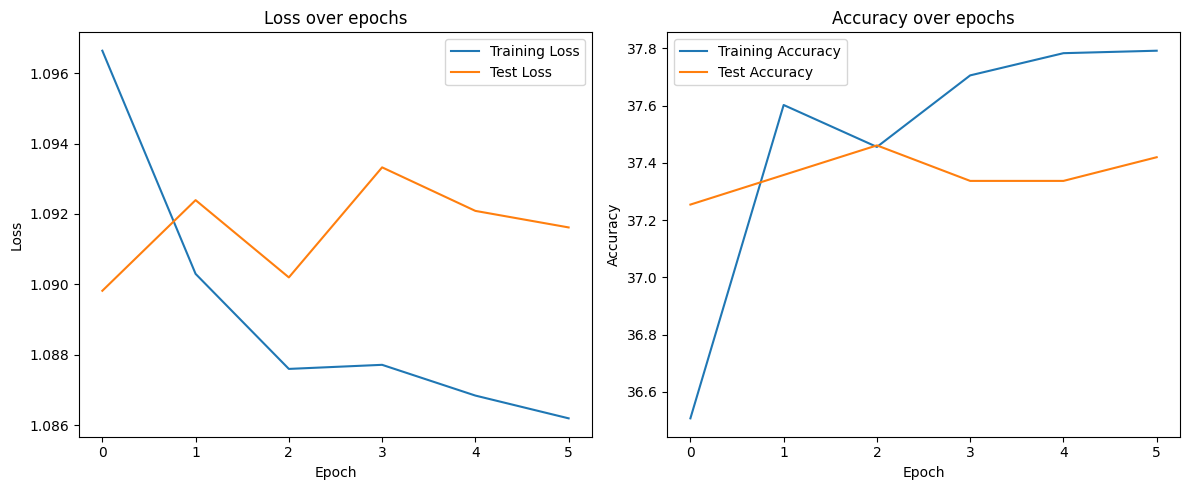

<Figure size 1200x500 with 2 Axes>

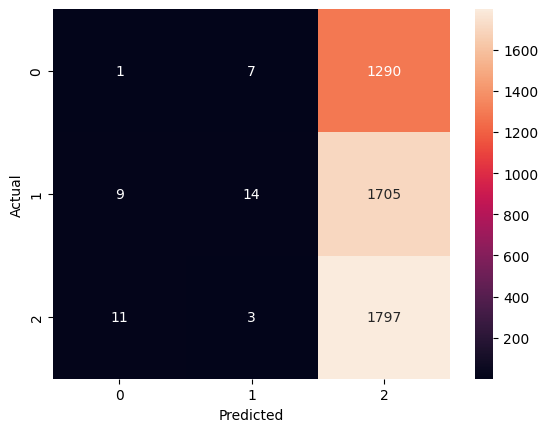

<Figure size 640x480 with 2 Axes>

37.4612363034939

In [25]:
# Evaluating the chosen model on the test dataset, showing graphs and confusion matrix
rnn_model = RNN(input_dim, rnn_embedding_dim, best_hidden_dim_RNN, output_dim,best_dropout_rate_RNN)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=best_lr_RNN) 
train_and_evaluate(rnn_model, train_loader, test_loader, rnn_optimizer, criterion, device, num_epochs,True,'Test')

### c) Discussion (10 pt)
<p style="font-size: 17px">
Discuss the differences in the methods you have tried. 
</p>

In this exercise we tried using the Vanilla RNN and LSTM methods. We found that the LSTM achieved better results - ~49% accuracy compared to ~37% accuracy of the RNN model. 

This finding makes sense because RNNs are typically good at recognizing patterns in data that's close together but struggle with long-distance patterns. This issue is due to the vanishing or exploding gradient problem, where, during training, the gradients can become too small or too large. We noticed this with our RNN model, where the loss and accuracy didn't change much over several epochs (a sign of vanishing gradients) or changed too drastically (a sign of exploding gradients). In contrast, LSTMs are designed to tackle this vanishing gradient issue and are better at learning from long-term patterns. This was evident as the LSTM's training was more stable compared to the RNN.

The key difference between the two lies in their structure. Vanilla RNNs have a straightforward design, where the current hidden state is calculated using the present input and the previous hidden state. LSTMs, however, have a more complex setup with input, forget, and output gates, plus a cell state. These features help LSTMs manage information flow more effectively and remember both recent and old data more efficiently.